This script accompanies Rodriguez Padilla and Arrowsmith, 202X. Here, we input post-earthquake digital elevation models and diffuse them to simulate the effect of surface processes over different timescales. Based on the changes in slope distribution over time, we quantify the information loss due to surface processes.

In [2]:
# First, import a few Python packages and landlab tools
import numpy as np
from pylab import show, figure, plot
import time
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_grid
from landlab.io import read_esri_ascii
import matplotlib.pyplot as plt
from osgeo import gdal
import glob
from PIL import Image
import matplotlib.cbook as cbook
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import LightSource

/usr/local/lib/python3.9/site-packages/landlab/plot/imshow.py:443: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("pink").copy()
  cmap.set_bad(color=color_for_closed)
/usr/local/lib/python3.9/site-packages/landlab/plot/imshow.py:483: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


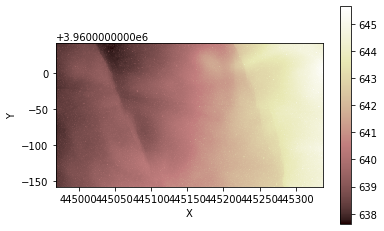

In [2]:
# load DEM
mg, z = read_esri_ascii('ridgecrest_twosegments.asc', name='topographic__elevation')
np.all(mg.at_node['topographic__elevation'] == z)
mg.set_fixed_value_boundaries_at_grid_edges(False, True, False, True)
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)
hillshade = mg.calc_hillshade_at_node(elevs=z, alt=30., az=100.)
imshow_grid(mg,z) # plot_type, 'Hillshade'
slope_t0 = mg.calc_slope_at_node(z)
z_t0 = z[mg.nodes]

Next, we will define our transport rate and 2D diffusion set-up

In [3]:
D = 0.01  # m2/yr transport coefficient
dt = 0.2 * mg.dx * mg.dx / D # set time step to 5 yrs
print(dt) # print time step to double check
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)
len(mg.core_nodes)
qs = mg.add_zeros('sediment_flux', at='link')

5.0


In [4]:
# create simulations of scarp evolution over time

n_iter =  100
total_time = n_iter * dt
info_loss = [None] * n_iter
slope_t0 = np.array(slope_t0)

print(total_time)

def make_gif():
    for i in range(n_iter):
        fig, ax = plt.subplots(2,2,tight_layout=True)
        fig.set_size_inches(7, 5)
        g = mg.calc_grad_at_link(z)
        qs[mg.active_links] = -D * g[mg.active_links]
        dzdt = -mg.calc_flux_div_at_node(qs)
        z[mg.core_nodes] += dzdt[mg.core_nodes] * dt
        hillshade = mg.calc_hillshade_at_node(elevs=z, alt=30., az=100.)
        slope_t = mg.calc_slope_at_node(z)
        ratio = slope_t0/slope_t
        ratio = ratio[np.logical_not(np.isnan(ratio))]
        ratio = np.mean(ratio)
        info_loss[i]= ratio
        zfin = z[mg.nodes]

        elev = mg.node_vector_to_raster(hillshade, flip_vertically=True)
        im1 = ax[0,0].imshow(elev,cmap='copper')
        
        scalebar = ScaleBar(0.5) # 1 pixel = 0.5 meters
        ax[0,0].add_artist(scalebar)
        
        z_diff =  zfin - z_t0

        zchange = mg.node_vector_to_raster(z_diff, flip_vertically=True)
        im2 = ax[1,0].imshow(zchange,cmap='cividis',vmin=-0.4, vmax=0.4)

        slope_t = np.array(slope_t)
        ax[0,1].hist(slope_t0,100,color='slategrey')
        ax[0,1].hist(slope_t,100,color='coral')
        ax[0,1].set_title('t = %.0f years' %(i*dt))
        ax[0,1].set_xlim([0, 0.8])
        ax[0,1].set_xlabel('Slope')
        ax[0,1].set_ylabel('Frequency')
        ax[0,1].set_ylim([0,50000])

        t = np.linspace(0,n_iter * dt,n_iter)
        ax[1,1].scatter(t,info_loss,color='coral')
        ax[1,1].set_ylabel('Degradation coefficient ($\phi$)')
        ax[1,1].set_xlabel('Time (years)')
        ax[1,1].set_ylim([1,8])
        ax[1,1].set_xlim([-1,total_time])

        ax[0,0].set_xticklabels([])
        ax[1,0].set_xticklabels([])
        ax[0,0].set_yticklabels([])
        ax[0,1].set_yticklabels([])
        ax[1,0].set_yticklabels([])
        fig.colorbar(im1, ax=ax[0,0],ticks=[])
        fig.colorbar(im2, ax=ax[1,0],label='Elevation difference (m)')
        plt.savefig('mytest'+str(i)+'.png',dpi=200)
 

500.0


In [5]:
# save simulations as individual GIFs

#make_gif()    
    
fp_in = "mytest*.png"
fp_out = "twosegments.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in),key=os.path.getmtime)]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=100, loop=0)
         

ValueError: not enough values to unpack (expected at least 1, got 0)

In [11]:
def hillshade(array,azimuth,angle_altitude):
    azimuth = 360.0 - azimuth 
    
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = angle_altitude*np.pi/180.
 
    shaded = np.sin(altituderad)*np.sin(slope) + np.cos(altituderad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)
    
    return 255*(shaded + 1)/2

In [24]:
# Figure 2

DEMnames = ['ridgecrest_multi.asc','ridgecrest_twosegments.asc','ridgecrest_linear.asc','multistrand.asc','multimaterial.asc']

n_iter = np.array([0,2,20,200,2000])    # equivalent years 0, 10, 100, 1000, 10000
fig, ax = plt.subplots(
    len(n_iter),len(DEMnames),
    tight_layout=True,
    figsize=(7, 5),
    dpi=200,
    gridspec_kw={"width_ratios":[1,4,2,1.5,3]}
)

for i,iDEM in enumerate(DEMnames):
    # landlab grid from DEM
    mg, z = read_esri_ascii(iDEM, name='topographic__elevation')
    mg.set_fixed_value_boundaries_at_grid_edges(False, True, False, True)
    mg.set_closed_boundaries_at_grid_edges(True, False, True, False)

    # model set-up for 2D diffusion
    D = 0.01  # m2/yr transport rate
    dt = 0.2 * mg.dx * mg.dx / D # time step is 5 years 
    mg.set_closed_boundaries_at_grid_edges(True, False, True, False)
    qs = mg.add_zeros('sediment_flux', at='link')

    # run model over time
    def imshow_noticks(AX,MG):
        fig.sca(AX)
        hillshade = mg.calc_hillshade_at_node(elevs=z, alt=30., az=100.)
        imshow_grid(MG,hillshade,cmap='copper') # plot_type, 'Hillshade'
        AX.set_xticklabels([])
        AX.set_yticklabels([])
        AX.set_xticks([])
        AX.set_yticks([])
        AX.set_ylabel('')
        AX.set_xlabel('')
        colorbar = plt.gci().colorbar
        colorbar.remove()

    plot_counter=0
    for p in range(max(n_iter)+1):
        if np.any(p == n_iter):
            imshow_noticks(ax[plot_counter,i],mg)
            plot_counter += 1
        g = mg.calc_grad_at_link(z)
        qs[mg.active_links] = -D * g[mg.active_links]
        dzdt = -mg.calc_flux_div_at_node(qs)
        z[mg.core_nodes] += dzdt[mg.core_nodes] * dt

    scalebar = ScaleBar(1) # 1 pixel = 0.5 meters
    ax[0,i].add_artist(scalebar)

/usr/local/lib/python3.9/site-packages/landlab/plot/imshow.py:443: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("copper").copy()
  cmap.set_bad(color=color_for_closed)
/usr/local/lib/python3.9/site-packages/landlab/plot/imshow.py:483: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


In [20]:
help(plt.GridSpec)

Help on class GridSpec in module matplotlib.gridspec:

class GridSpec(GridSpecBase)
 |  GridSpec(nrows, ncols, figure=None, left=None, bottom=None, right=None, top=None, wspace=None, hspace=None, width_ratios=None, height_ratios=None)
 |  
 |  A grid layout to place subplots within a figure.
 |  
 |  The location of the grid cells is determined in a similar way to
 |  `~.figure.SubplotParams` using *left*, *right*, *top*, *bottom*, *wspace*
 |  and *hspace*.
 |  
 |  Method resolution order:
 |      GridSpec
 |      GridSpecBase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getstate__(self)
 |  
 |  __init__(self, nrows, ncols, figure=None, left=None, bottom=None, right=None, top=None, wspace=None, hspace=None, width_ratios=None, height_ratios=None)
 |      Parameters
 |      ----------
 |      nrows, ncols : int
 |          The number of rows and columns of the grid.
 |      
 |      figure : `~.figure.Figure`, optional
 |          Only used for constrained layout 

In [19]:
help(plt.subplots)

Help on function subplots in module matplotlib.pyplot:

subplots(nrows=1, ncols=1, *, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, **fig_kw)
    Create a figure and a set of subplots.
    
    This utility wrapper makes it convenient to create common layouts of
    subplots, including the enclosing figure object, in a single call.
    
    Parameters
    ----------
    nrows, ncols : int, default: 1
        Number of rows/columns of the subplot grid.
    
    sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
        Controls sharing of properties among x (*sharex*) or y (*sharey*)
        axes:
    
        - True or 'all': x- or y-axis will be shared among all subplots.
        - False or 'none': each subplot x- or y-axis will be independent.
        - 'row': each subplot row will share an x- or y-axis.
        - 'col': each subplot column will share an x- or y-axis.
    
        When subplots have a shared x-axis along a column, on

In [9]:
gs = plt.GridSpec(2,2,width_ratios=[1,2])